In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from os import listdir
import glob
from PIL import Image
import cv2
from random import randrange
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
ori_images = 'DATASET/TRAIN/ORIGINAL'
mask_images = 'DATASET/TRAIN/MASKS'

In [4]:
def load_data(dataset_path, split=0.2):
    images = [f for f in glob.glob(ori_images + "**/*.jpg", recursive=True)]
    masks = [f for f in glob.glob(mask_images + "**/*.jpg", recursive=True)]

    test_size = int(len(images) * split)

    train_x, test_x = train_test_split(images, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(masks, test_size=test_size, random_state=42)

    return (train_x, train_y), (test_x, test_y)

In [5]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)  
    x = cv2.resize(x, (128, 128))
    x = x/255.0
    x = x.astype(np.float32)
    return x 

In [6]:
def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  
    x = cv2.resize(x, (128, 128))
    x = x/255.0
    x = x.astype(np.float32)                    
    x = np.expand_dims(x, axis=-1)              
    return x

In [7]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float32, tf.float32])
    x.set_shape([128, 128, 3])
    y.set_shape([128, 128, 1])
    return x, y

def tf_dataset(X, Y, batch):
    dataset = tf.data.Dataset.from_tensor_slices((X, Y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(10)
    return dataset

In [8]:
dataset_path = "Dataset"
(train_x, train_y), (test_x, test_y) = load_data(dataset_path)

print(f"Train: {len(train_x)} - {len(train_y)}")
print(f"Test: {len(test_x)} - {len(test_y)}")

Train: 120 - 120
Test: 30 - 30


In [9]:
batch = 4
train_dataset = tf_dataset(train_x, train_y, batch)
valid_dataset = tf_dataset(test_x, test_y, batch)

In [10]:
def conv_block(inputs, num_filters):
    x = Conv2D(num_filters, 3, padding="same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(inputs, num_filters):
    x = conv_block(inputs, num_filters)
    p = MaxPool2D((2, 2))(x)
    return x, p

def decoder_block(inputs, skip_features, num_filters):
    x = Conv2DTranspose(num_filters, (2, 2), strides=2, padding="same")(inputs)
    x = Concatenate()([x, skip_features])
    x = conv_block(x, num_filters)
    return x

def build_unet(input_shape):
    inputs = Input(input_shape)

    """ Encoder """
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    s4, p4 = encoder_block(p3, 512)

    """ Bridge """
    b1 = conv_block(p4, 1024)

    """ Decoder """
    d1 = decoder_block(b1, s4, 512)
    d2 = decoder_block(d1, s3, 256)
    d3 = decoder_block(d2, s2, 128)
    d4 = decoder_block(d3, s1, 64)

    """ Outputs """
    outputs = Conv2D(1, 1, padding="same", activation="sigmoid")(d4)

    """ Model """
    model = Model(inputs, outputs)
    return model

In [11]:
model = build_unet((128, 128, 3))
model.compile(loss="binary_crossentropy", optimizer=Adam(), metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                             

 batch_normalization_9 (BatchNo  (None, 8, 8, 1024)  4096        ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_9 (Activation)      (None, 8, 8, 1024)   0           ['batch_normalization_9[0][0]']  
                                                                                                  
 conv2d_transpose (Conv2DTransp  (None, 16, 16, 512)  2097664    ['activation_9[0][0]']           
 ose)                                                                                             
                                                                                                  
 concatenate (Concatenate)      (None, 16, 16, 1024  0           ['conv2d_transpose[0][0]',       
                                )                                 'activation_7[0][0]']           
          

 batch_normalization_17 (BatchN  (None, 128, 128, 64  256        ['conv2d_17[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_17 (Activation)     (None, 128, 128, 64  0           ['batch_normalization_17[0][0]'] 
                                )                                                                 
                                                                                                  
 conv2d_18 (Conv2D)             (None, 128, 128, 1)  65          ['activation_17[0][0]']          
                                                                                                  
Total params: 31,055,297
Trainable params: 31,043,521
Non-trainable params: 11,776
__________________________________________________________________________________________________


In [12]:
model_path = 'CRACK.h5'
callbacks = [
        ModelCheckpoint(model_path, verbose=1, save_best_only=True, monitor = 'accuracy')
    ]

In [13]:
batch_size = 32
num_epoch = 20

In [14]:
model.fit(
    train_dataset.repeat(),
    epochs=num_epoch,
    validation_data=valid_dataset.repeat(),
    steps_per_epoch=len(train_x)//batch_size,
    validation_steps=len(test_x)//batch_size,
    callbacks=callbacks
)

Epoch 1/20
3/3 [==============================] - ETA: 0s - loss: 0.6164 - accuracy: 0.6817
Epoch 1: accuracy improved from -inf to 0.68169, saving model to CRACK.h5
3/3 [==============================] - 20s 5s/step - loss: 0.6164 - accuracy: 0.6817
Epoch 2/20
3/3 [==============================] - ETA: 0s - loss: 0.4479 - accuracy: 0.8808
Epoch 2: accuracy improved from 0.68169 to 0.88084, saving model to CRACK.h5
3/3 [==============================] - 19s 8s/step - loss: 0.4479 - accuracy: 0.8808
Epoch 3/20
3/3 [==============================] - ETA: 0s - loss: 0.3266 - accuracy: 0.9468
Epoch 3: accuracy improved from 0.88084 to 0.94682, saving model to CRACK.h5
3/3 [==============================] - 12s 4s/step - loss: 0.3266 - accuracy: 0.9468
Epoch 4/20
3/3 [==============================] - ETA: 0s - loss: 0.2470 - accuracy: 0.9569
Epoch 4: accuracy improved from 0.94682 to 0.95694, saving model to CRACK.h5
3/3 [==============================] - 11s 4s/step - loss: 0.2470 - accu

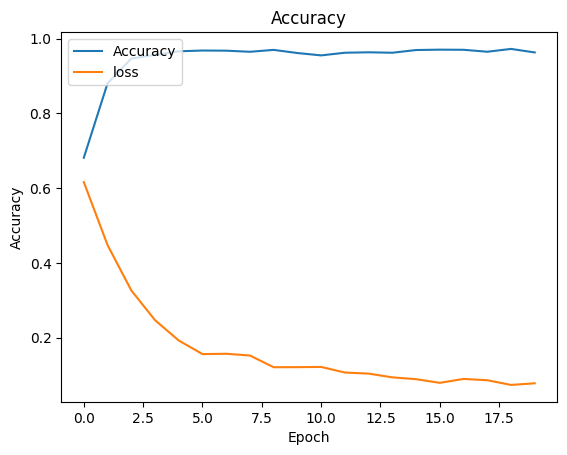

In [16]:
def graph():
    #Plot training & validation accuracy values
    plt.plot(model.history.history['accuracy'])
    plt.plot(model.history.history['loss'])
    plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Accuracy', 'loss'], loc='upper left')
    plt.show()
graph()